# Catboost Classifier
* also feature importance
* also grid search

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# ps -fA | grep python
# kill -9 PID (i.e. the pid returned)

In [2]:
!pip install shap

In [115]:
!pip install shap
!pip install catboost
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets
from sklearn import decomposition
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import plot_confusion_matrix
from pathlib import Path
import os
import matplotlib.pyplot as plt
#import cupy as np
#import gnumpy as gpu
import numpy as np
from catboost import CatBoost
from sklearn import preprocessing
from catboost.utils import eval_metric
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import pickle
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

### Normalize the data: fill nan, filter out any biomes < k counts


In [2]:
def read_in_data_filter_integer_labels(grouped = 30,
                        csv = "/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/copy_number_abundance.csv"):
    df = pd.read_csv(csv)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.fillna(0)

    grouped_df = df.groupby('biome').filter(lambda x : len(x) > grouped)
    grouped_df = grouped_df.reset_index(drop=True)
    print(grouped_df['biome'].nunique())

    
    # drop constant columns
    print(grouped_df.shape)
    # record columns to delete
    counts = grouped_df.nunique()
    to_del = [i for i,v in enumerate(counts) if v == 1]
    print('constant columns: ',to_del)
    # drop useless columns
    grouped_df.drop(grouped_df.columns[[to_del]],axis = 1, inplace=True)
    print(grouped_df.shape)
    
    le = preprocessing.LabelEncoder()
    le.fit(grouped_df.biome)
    #list(le.classes_)
    le.transform(grouped_df.biome)
    
    return grouped_df, le

In [3]:
# github from ziming
# https://github.com/Yzm1234/KE/blob/master/lib/ plot and data_prepare

def dataset_split(df, train=0.7, val=0.2, test=0.1, random_state=42):
    df_train, df_rest = train_test_split(df, train_size=train, random_state=random_state, stratify=df['biome'])
    val_test_ratio = val/(val+test)
    df_val, df_test = train_test_split(df_rest, train_size=val_test_ratio, random_state=random_state, stratify=df_rest['biome'])
    return df_train, df_val, df_test
def plot_training_curve(catboost_info_path, loss_function, metrics, epoch):
    Path("output").mkdir(exist_ok=True)
    train_tsv = os.path.join(catboost_info_path, "learn_error.tsv")
    val_tsv = os.path.join(catboost_info_path, "test_error.tsv")
    with open(train_tsv, 'r') as f:
        train_info = pd.read_csv(f, sep="\t")
    with open(val_tsv, 'r') as f:
        val_info = pd.read_csv(f, sep="\t")
    fig, ax = plt.subplots()
    ax.plot(list(range(epoch)), train_info[loss_function], label="train loss", color='blue')
    ax.plot(list(range(epoch)), val_info[loss_function], label="val loss", color='blue', linestyle='dashed')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss Function")
    ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    ax2 = ax.twinx()
    ax2.plot(list(range(epoch)), train_info[metrics], label="train acc", color='red')
    ax2.plot(list(range(epoch)), val_info[metrics], label="val acc", color='red', linestyle='dashed')
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.8))
    plt.savefig("output/training_curve.png", bbox_inches='tight')
    plt.show()

def split_the_data_set(X_, y_, random_state=42):
    X_['biome'] = y_
    ### split dataset
    df_train, df_val, df_test = dataset_split(X_, random_state=random_state)
    
    y_ = X_['biome']
    X_ = X_.drop('biome', axis=1)
    ### Prep Catboost pool
    X_train = df_train.drop('biome', axis=1)
    y_train = df_train['biome']
    X_train_pool = Pool(data=X_train, label=y_train,)

    X_val = df_val.drop('biome', axis=1)
    y_val = df_val['biome']
    X_val_pool = Pool(data=X_val,label=y_val)

    X_test = df_test.drop('biome', axis=1)
    y_test = df_test['biome']
    
    return X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test 
def fit_data(leng):
    model.fit(X_train_pool, eval_set=X_val_pool, plot=True,snapshot_file='missing',)
    print("Test data score: "+str(model.score(X_test, y_test)))
    print("Validate data score: "+str(model.score(X_val, y_val)))
    print("Train data score: "+str(model.score(X_train, y_train)))
    plot_training_curve("catboost_info", "MultiClass", "Accuracy", leng)

def confusion_matrix(model, X_test, y_test):
    #Path("output").mkdir(exist_ok=True)
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
    fig = plt.gcf()
    fig.set_size_inches(20, 15)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('prediction', fontsize=40)
    plt.ylabel('true', fontsize=40)
    #fig.savefig('output/confusion_matrix.png', dpi=500, bbox_inches='tight')
    plt.show()

# function calls 

In [4]:
#g, le = read_in_data_filter_integer_labels(grouped=30)
g, le = read_in_data_filter_integer_labels(grouped=0) #0!!!

78
(16223, 14992)
constant columns:  []


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(16223, 14992)


In [6]:
g # make a cluster diagram of only human fecal
g_copy = g.copy()

In [5]:
g = g[g.biome=='Host-associated:Mammals: Human:Large intestine']

In [25]:
concat = pd.read_csv('/global/cfs/cdirs/kbase/KE-Catboost/HK/113K_copy_number_abundance.csv')
concat = concat.drop(['Unnamed: 0'],axis=1)

In [26]:
concat = concat[concat.biome=='Host-associated:Mammals: Human:Large intestine']
concat = concat.loc[:,~(concat.sum(axis=0) == 0)]

#h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
#h['GOLD Analysis Project ID'] = h.GOLD
#h.head()

concat = concat.merge(h[['GOLD Analysis Project ID', 'Disease']], on='GOLD Analysis Project ID', how='left')
concat = concat.drop(['biome','GOLD Analysis Project ID'],axis=1)
concat['biome'] = concat.Disease
concat = concat.drop(['Disease'],axis=1)

In [24]:
pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/protein_abundance_metagenomes.csv",nrows=5)

,Unnamed: 0,GOLD Analysis Project ID,gene_copy,count
0,0,Ga0026756,227358,2658
1,1,Ga0246665,1027,79
2,2,Ga0233425,1297294,54716
3,3,Ga0208790,35047,2511
4,4,Ga0207582,36740,4137


In [53]:
grouped_df = df.copy()
# rename the unclassified that we want to keep in the model, not as complex ecosystem
grouped_df.loc[grouped_df.biome == 'Host-associated:Annelida:Unclassified','biome'] = 'Host-associated:Annelida:Digestive tube'
grouped_df.loc[grouped_df.biome == 'Host-associated:Arthropoda: Insects:Unclassified','biome']='Host-associated:Arthropoda: Insects'
grouped_df.loc[grouped_df.biome == 'Engineered:WWTP:Unclassified','biome'] = 'Engineered:WWTP'
grouped_df.loc[grouped_df.biome == 'Engineered:Modeled:Unclassified','biome'] = 'Engineered:Modeled'
grouped_df.loc[grouped_df.biome == 'Host-associated:Porifera:Unclassified','biome']='Host-associated:Porifera'
grouped_df.loc[grouped_df.biome == 'Host-associated:Algae:Unclassified','biome']='Host-associated:Algae'
grouped_df.loc[grouped_df.biome == 'Engineered:Bioreactor:Unclassified','biome']='Engineered:Bioreactor'

print("before dropping: ",grouped_df['biome'].nunique())
# filter out any biomes without many CDS counts
#grouped_df = grouped_df[grouped_df["assembled.CDS.Count"]>50000]

# filter out the biomes not clearly defined
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Aquatic:Lentic']
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Peat']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Glacier']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Boreal forest/Taiga']
print("dropped biomes-\nEnvironmental:Aquatic:Lentic\nEnvironmental:Terrestrial:Peat")

#drop unclassified biomes
dropped = grouped_df[grouped_df["biome"].str.contains("Unclassified")==True]
print(dropped.biome.drop_duplicates())
grouped_df = grouped_df[grouped_df["biome"].str.contains("Unclassified")==False]

#drop biomes < 30 metagenomes
which_less = grouped_df.groupby('biome').filter(lambda x : len(x) < 30)
print(which_less.biome.drop_duplicates())
grouped_df = grouped_df.groupby('biome').filter(lambda x : len(x) > 30)

grouped_df = grouped_df.reset_index(drop=True)
print("after dropping: ", grouped_df['biome'].nunique())
grouped_df = grouped_df.drop(['GOLD Analysis Project ID'], axis=1)#, "assembled.CDS.Count", 'biome_specific'], axis=1)


before dropping:  77
dropped biomes-
Environmental:Aquatic:Lentic
Environmental:Terrestrial:Peat
28            Environmental:Terrestrial:Unclassified
30                Environmental:Aquatic:Unclassified
85                Engineered:Wastewater:Unclassified
1332             Host-associated:Plants:Unclassified
1427                  Environmental:Air:Unclassified
1739              Host-associated:Fungi:Unclassified
2201    Engineered:Artificial ecosystem:Unclassified
Name: biome, dtype: object
154                      Engineered:Modeled
4092     Environmental:Terrestrial:Sediment
14744     Environmental:Aquatic:Marine lake
Name: biome, dtype: object
after dropping:  64


# Catboost

* below is for disease states, edit the biome labels to swap to all biomes and not just human gut

In [ ]:
print(len(g_copy))
print(len(g_copy[g_copy["assembled.CDS.Count"]>20000]))
g_copy['assembled.CDS.Count'].hist()

In [21]:
grouped_df = pfam.drop('GOLD Analysis Project ID',axis=1)

In [ ]:
#grouped_df.loc[grouped_df["biome"].str.contains("Unclassified")==True,'biome'] = grouped_df.loc[grouped_df["biome"].str.contains("Unclassified")==True,'biome_specific']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Aquatic:Lentic']
#grouped_df = grouped_df[grouped_df["biome"].str.contains("Environmental")==True]
#grouped_df['biome'] = grouped_df['biome_specific'] 

In [57]:
grouped_df = g.copy()
# rename the unclassified that we want to keep in the model, not as complex ecosystem
grouped_df.loc[grouped_df.biome == 'Host-associated:Annelida:Unclassified','biome'] = 'Host-associated:Annelida:Digestive tube'
grouped_df.loc[grouped_df.biome == 'Host-associated:Arthropoda: Insects:Unclassified','biome']='Host-associated:Arthropoda: Insects'
grouped_df.loc[grouped_df.biome == 'Engineered:WWTP:Unclassified','biome'] = 'Engineered:WWTP'
grouped_df.loc[grouped_df.biome == 'Engineered:Modeled:Unclassified','biome'] = 'Engineered:Modeled'
grouped_df.loc[grouped_df.biome == 'Host-associated:Porifera:Unclassified','biome']='Host-associated:Porifera'
grouped_df.loc[grouped_df.biome == 'Host-associated:Algae:Unclassified','biome']='Host-associated:Algae'
grouped_df.loc[grouped_df.biome == 'Engineered:Bioreactor:Unclassified','biome']='Engineered:Bioreactor'

print("before dropping: ",grouped_df['biome'].nunique())
# filter out any biomes without many CDS counts
#grouped_df = grouped_df[grouped_df["assembled.CDS.Count"]>50000]

before dropping:  77


In [58]:
# filter out the biomes not clearly defined
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Aquatic:Lentic']
grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Peat']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Glacier']
#grouped_df = grouped_df[grouped_df.biome != 'Environmental:Terrestrial:Boreal forest/Taiga']
print("dropped biomes-\nEnvironmental:Aquatic:Lentic\nEnvironmental:Terrestrial:Peat")

#drop unclassified biomes
dropped = grouped_df[grouped_df["biome"].str.contains("Unclassified")==True]
print(dropped.biome.drop_duplicates())
grouped_df = grouped_df[grouped_df["biome"].str.contains("Unclassified")==False]

#drop biomes < 30 metagenomes
which_less = grouped_df.groupby('biome').filter(lambda x : len(x) < 30)
print(which_less.biome.drop_duplicates())
grouped_df = grouped_df.groupby('biome').filter(lambda x : len(x) > 30)

grouped_df = grouped_df.reset_index(drop=True)
print("after dropping: ", grouped_df['biome'].nunique())
grouped_df = grouped_df.drop(['GOLD Analysis Project ID'], axis=1)#, "assembled.CDS.Count", 'biome_specific'], axis=1)

dropped biomes-
Environmental:Aquatic:Lentic
Environmental:Terrestrial:Peat
3                 Environmental:Aquatic:Unclassified
29            Environmental:Terrestrial:Unclassified
256              Host-associated:Plants:Unclassified
642               Engineered:Wastewater:Unclassified
649               Host-associated:Fungi:Unclassified
1312    Engineered:Artificial ecosystem:Unclassified
4507                  Environmental:Air:Unclassified
Name: biome, dtype: object
330                      Engineered:Modeled
3918     Environmental:Terrestrial:Sediment
10558     Environmental:Aquatic:Marine lake
Name: biome, dtype: object
after dropping:  64


In [46]:
grouped_df = grouped_df[grouped_df.biome.str.contains('0') == False].reset_index(drop=True)
grouped_df = grouped_df.groupby('biome').filter(lambda x : len(x) > 30)

In [22]:
#Disease
grouped_df = g
grouped_df['biome'] = g.Disease
grouped_df = grouped_df.drop('Disease',axis=1)
#grouped_df.loc[grouped_df.biome == 'Adenoma','biome'] = 'Cancer'
grouped_df = grouped_df.groupby('biome').filter(lambda x : len(x) > 14)

In [23]:
grouped_df = grouped_df.drop('GOLD Analysis Project ID',axis=1)
grouped_df = grouped_df.loc[:,~(grouped_df.sum(axis=0) == 0)]

In [24]:
grouped_df.biome.value_counts()

Normal                                                 461
Newborn                                                145
V. cholera challenge study.                            104
Dysbiosis in Rheumatoid Arthritis                       82
obese patients following a weight-loss intervention     79
microbial dysbiosis in young adults with obesity        72
Type 2 Diabetes                                         42
ETEC H10407 challenge study.                            32
Adenoma                                                 15
Name: biome, dtype: int64

In [15]:
le = preprocessing.LabelEncoder()
le.fit(grouped_df.biome)
    #list(le.classes_)
le.transform(grouped_df.biome)

array([7, 6, 6, ..., 7, 7, 7])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0851219	test: 2.0893636	best: 2.0893636 (0)	total: 22.8ms	remaining: 45.6s
1999:	learn: 0.0558894	test: 0.5691930	best: 0.5686133 (1997)	total: 36.1s	remaining: 0us
bestTest = 0.5686132931
bestIteration = 1997
Shrink model to first 1998 iterations.
Test data score: 0.7403846153846154
Validate data score: 0.7815533980582524
Train data score: 1.0


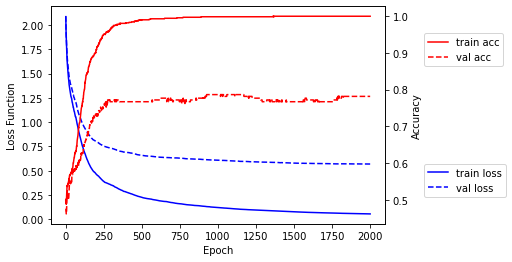

In [63]:
le = preprocessing.LabelEncoder()
le.fit(grouped_df.biome)
y_ = le.transform(grouped_df.biome)
X_ = grouped_df.drop(['biome'], axis=1)
#X_ = select_k_best_feature_selection(X_, y_, kind=f_classif, k=1000)
X_ = X_.fillna(0)
model = CatBoostClassifier(learning_rate=0.1, depth = 6, l2_leaf_reg=10, bootstrap_type = 'Bernoulli',
                          # border_count=5, max_ctr_complexity= 1, bagging_temperature= 0.03, 
                           random_strength= 30,iterations=2000,
                           verbose = 2000,random_seed=42,loss_function='MultiClass',
                           custom_metric='Accuracy',task_type="GPU",)
X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, le.inverse_transform(y_), random_state=42)
fit_data(leng=2000)

In [ ]:
model = CatBoostClassifier(learning_rate=0.1, depth = 6, l2_leaf_reg=10, bootstrap_type = 'Bernoulli',
                          # border_count=5, max_ctr_complexity= 1, bagging_temperature= 0.03, 
                           random_strength= 30,iterations=2000,
                           verbose = 2000,random_seed=42,loss_function='MultiClass',
                           custom_metric='Accuracy',task_type="GPU",)

In [79]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
pd.options.display.float_format = "{:,.2f}".format
print(df_classification_report.to_string())

                                                     precision  recall  f1-score  support
Adenoma                                                   1.00    1.00      1.00     1.00
Newborn                                                   0.82    0.93      0.87    15.00
Normal                                                    0.73    0.93      0.82    46.00
V. cholera challenge study.                               0.82    0.82      0.82    11.00
accuracy                                                  0.73    0.73      0.73     0.73
weighted avg                                              0.72    0.73      0.70   104.00
macro avg                                                 0.71    0.56      0.59   104.00
ETEC H10407 challenge study.                              1.00    0.33      0.50     3.00
microbial dysbiosis in young adults with obesity          0.60    0.43      0.50     7.00
obese patients following a weight-loss intervention       1.00    0.25      0.40     8.00
Dysbiosis 

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


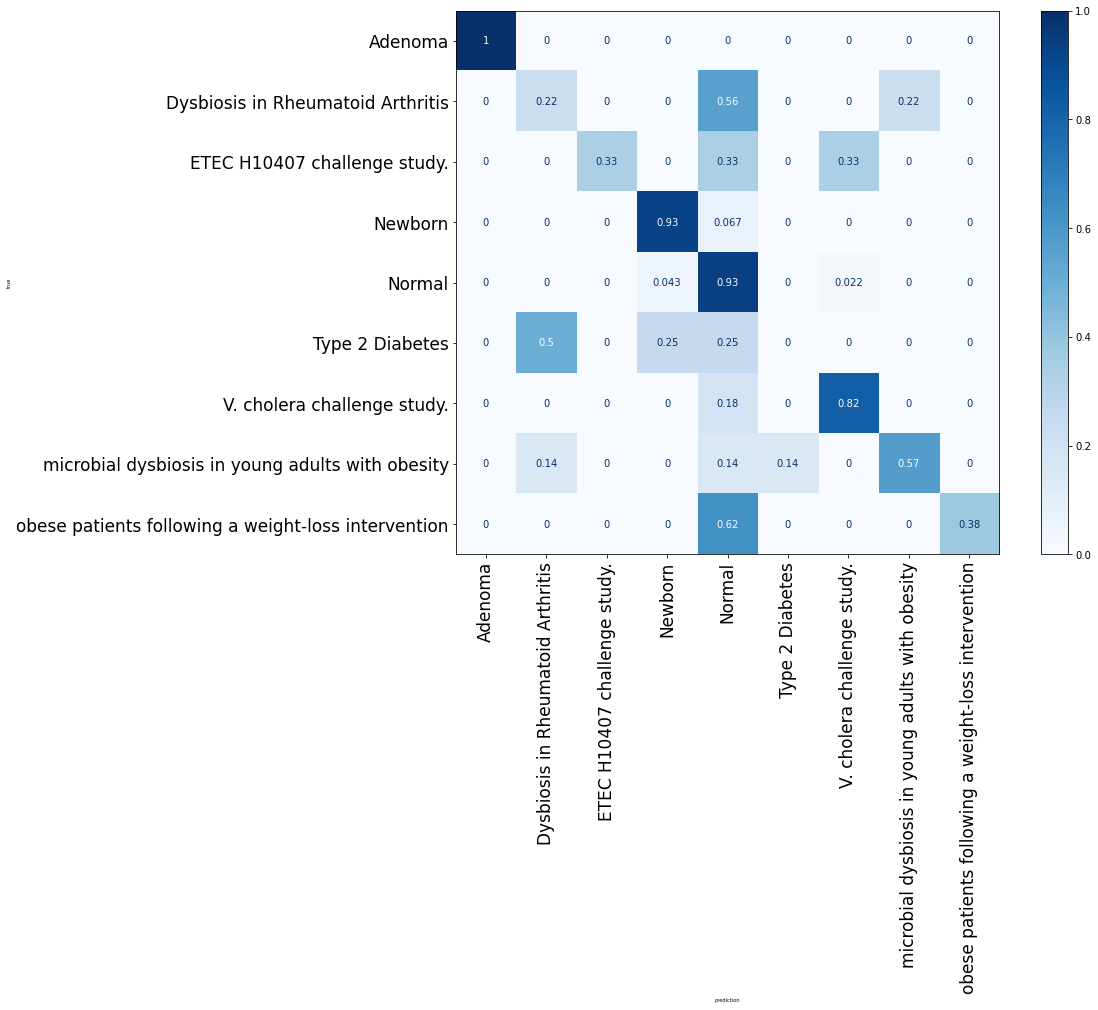

In [64]:
def confusion_matrix(model, X_test, y_test):
    #Path("output").mkdir(exist_ok=True)
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.xticks(rotation=90, fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlabel('prediction', fontsize=5)
    plt.ylabel('true', fontsize=5)
    #fig.savefig('output/confusion_matrix.png', dpi=500, bbox_inches='tight')
    plt.show()
confusion_matrix(model, X_test, y_test)

# grid search disease

In [ ]:
# Best Params :  {'l2_leaf_reg': 25, 'iterations': 5000, 'learning_rate': 0.1, 'bootstrap_type': 'Bayesian'}

model = CatBoostClassifier(learning_rate=0.3, bootstrap_type = 'Bayesian', depth = 8, l2_leaf_reg=10,
                           random_strength= 0.8,iterations=2000,
                           verbose = 500,random_seed=42,loss_function='MultiClass',
                           custom_metric='Accuracy',task_type="GPU",)
grid = {'iterations':[2000],'learning_rate': [0.3, 0.1],'l2_leaf_reg': [5, 10],
        'bootstrap_type':['Bayesian', 'Bernoulli', 'No'], }
#grid_search_result = model.grid_search(grid, X_, y_, plot=False)
#print("\nBest Params : ", grid_search_result['params'])

X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, y_, random_state=42)
fit_data(leng=2000)

In [ ]:
learning_rate=0.1, depth = 6, l2_leaf_reg=10, bootstrap_type = 'Bernoulli',
                          # border_count=5, max_ctr_complexity= 1, bagging_temperature= 0.03, 
                           random_strength= 30,iterations=2000,

# Feature importance - shap

In [65]:
%time
shap_values_2 = shap.TreeExplainer(model).shap_values(X_test) 

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 8.58 µs


In [87]:
%%time
with open('shap_values_disease.pkl', 'wb') as f:
    pickle.dump(shap_values_2, f)

CPU times: user 8.06 ms, sys: 233 µs, total: 8.3 ms
Wall time: 8.46 ms


In [13]:
grouped_df = g.copy()
g = grouped_df.drop('GOLD Analysis Project ID',axis=1)

In [25]:
le = preprocessing.LabelEncoder()
le.fit(grouped_df.biome)
y_ = le.transform(grouped_df.biome)
X_ = grouped_df.drop(['biome'], axis=1)
#X_ = select_k_best_feature_selection(X_, y_, kind=f_classif, k=4000)
X_ = X_.fillna(0)
X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, le.inverse_transform(y_), random_state=42)

shap_values_2 = pd.read_pickle('shap_values_disease.pkl')

# Disease states - human

In [26]:
y_test_transform=pd.DataFrame(y_test)
y_test_transform['y_transform'] = le.transform(y_test)
for index, row in y_test_transform.drop_duplicates().iterrows():
    print(row['biome'], row['y_transform'])

obese patients following a weight-loss intervention 8
Normal 4
Dysbiosis in Rheumatoid Arthritis 1
microbial dysbiosis in young adults with obesity 7
V. cholera challenge study. 6
Adenoma 0
Newborn 3
ETEC H10407 challenge study. 2
Type 2 Diabetes 5


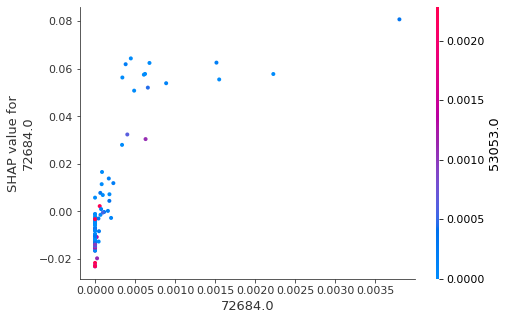

In [88]:
shap.dependence_plot('72684.0', shap_values_2[3],  X_test)

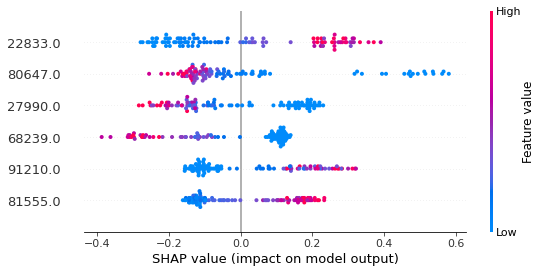

(None,)

In [108]:
shap.summary_plot(shap_values_2[0], X_test, feature_names = X_test.columns,max_display=6), #class_names=model.classes_) 

In [ ]:
obese patients following a weight-loss intervention 8
Normal 4
Dysbiosis in Rheumatoid Arthritis 1
microbial dysbiosis in young adults with obesity 7
V. cholera challenge study. 6
Adenoma 0
Newborn 3
ETEC H10407 challenge study. 2
Type 2 Diabetes 5

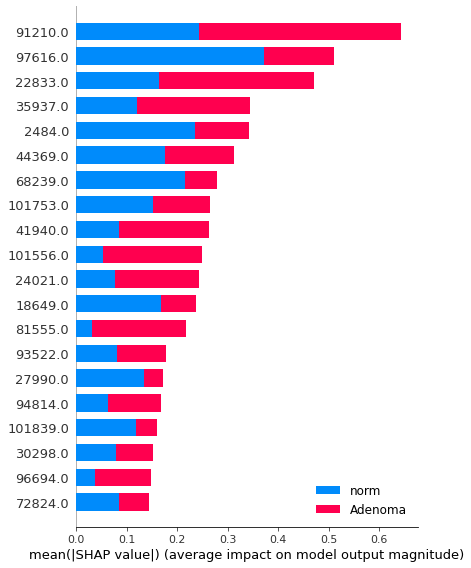

In [107]:
array = []
biomes_to_scope = [6,4]
labels = ['Adenoma', 'norm', "norm",]
for b in biomes_to_scope:
    array.append(shap_values_2[b])
    
shap.summary_plot(array, class_names= labels, #X_test_mouth, 
                  feature_names = X_test.columns, max_display=20,
                  plot_size = (6,8))

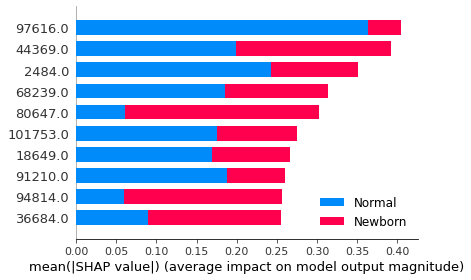

In [104]:
array = []
biomes_to_scope = [3, 4]
labels = ['Newborn', 'Normal']
for b in biomes_to_scope:
    array.append(shap_values_2[b])
    
shap.summary_plot(array, class_names= labels, #X_test_mouth, 
                  feature_names = X_test.columns, max_display=10,
                  plot_size = (6,4))

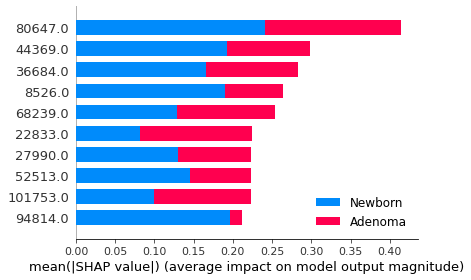

In [105]:
array = []
biomes_to_scope = [3, 0]
labels = ['Newborn', 'Adenoma']
for b in biomes_to_scope:
    array.append(shap_values_2[b])
    
shap.summary_plot(array, class_names= labels, #X_test_mouth, 
                  feature_names = X_test.columns, max_display=10,
                  plot_size = (6,4))

# large intesting, oral cavity

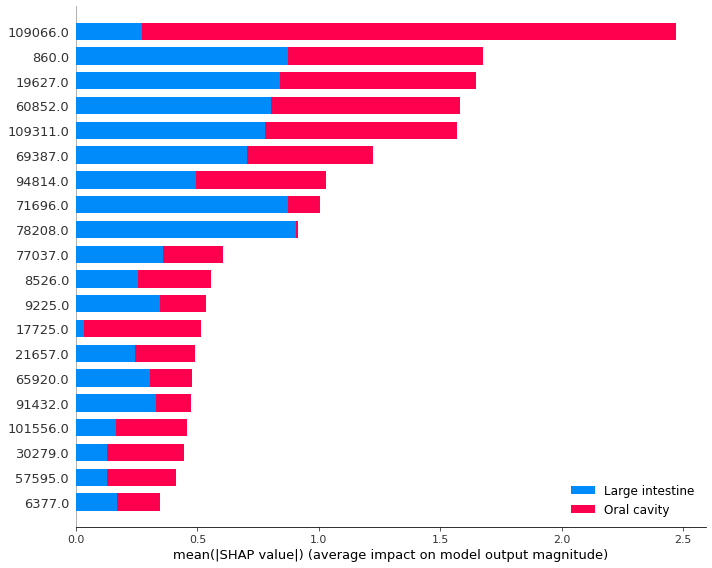

In [31]:
array = []
biomes_to_scope = [53, 54]
labels = ['Large intestine', 'Oral cavity',]
for b in biomes_to_scope:
    array.append(shap_values_2[b])
    
shap.summary_plot(array, class_names= labels, #X_test_mouth, 
                  feature_names = X_test.columns, max_display=20,
                  plot_size = (10,8))

# Comparing salinity in lake / saline aquatic

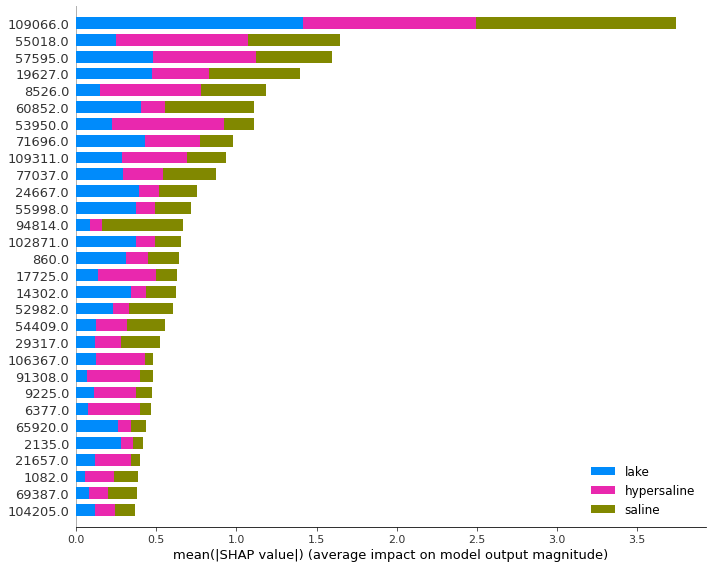

In [17]:
# 16 hypersaline
# 23 saline
# 20 lake

array = []
biomes_to_scope = [16, 23, 20]
labels = ['hypersaline', 'saline', 'lake']
for b in biomes_to_scope:
    array.append(shap_values_2[b])
shap.summary_plot(array, class_names= labels, #X_test_mouth, 
                  feature_names = X_test.columns, max_display=30,
                  plot_size = (10,8))

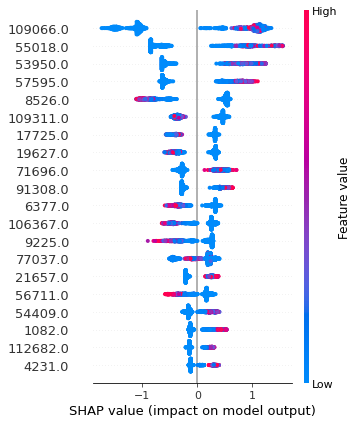

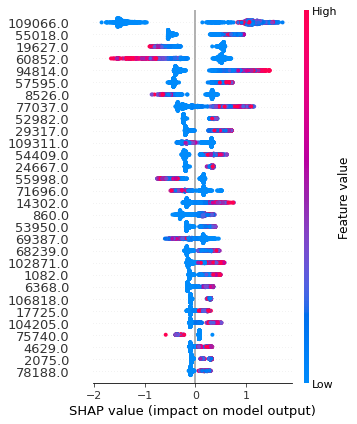

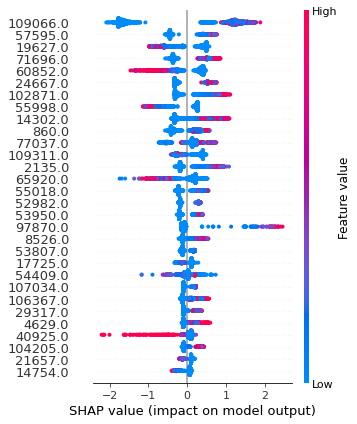

(None,)

In [31]:
# 16 hypersaline
# 23 saline
# 20 lake
shap.summary_plot(shap_values_2[16], X_test, feature_names = X_test.columns, plot_size = (5,6)), #class_names=model.classes_) 
shap.summary_plot(shap_values_2[23], X_test, feature_names = X_test.columns, max_display=30,plot_size = (5,6)), #class_names=model.classes_) 
shap.summary_plot(shap_values_2[20], X_test, feature_names = X_test.columns, max_display=30,plot_size = (5,6)), #class_names=model.classes_) 


# SHAP for entire model

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


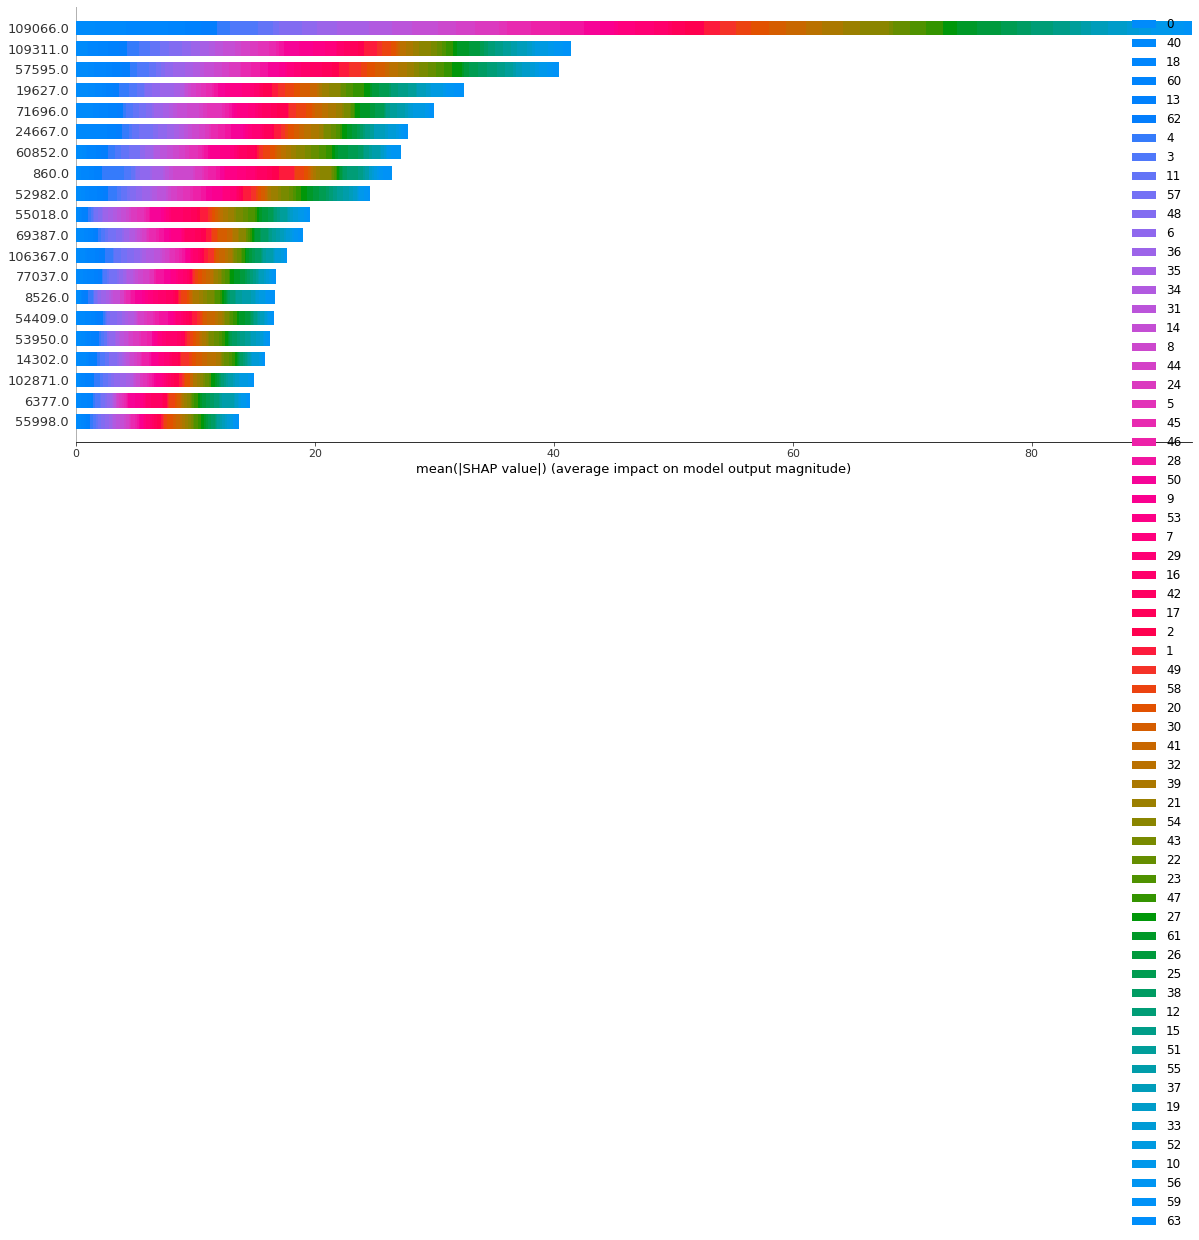

CPU times: user 6.64 s, sys: 1.47 s, total: 8.11 s
Wall time: 8.1 s


In [72]:
%%time
shap.summary_plot(shap_values_2, X_test, class_names= model.classes_, 
                  feature_names = X_test.columns, plot_size = (20,8))

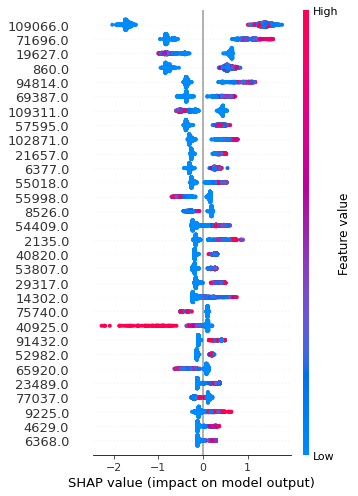

In [30]:
shap.summary_plot(shap_values_2[2], X_test, feature_names = X_test.columns,
                 max_display=30,plot_size = (5,7)) 

# Grid Search

In [ ]:
{'border_count': 200, 'max_ctr_complexity': 1, 'depth': 8,
 'bagging_temperature': 0.25, 'random_strength': 0.5, 'learning_rate': 0.1, 'bootstrap_type': 'Bayesian'}

In [ ]:
'border_count':[5], 'bagging_temperature':[0.03],
'random_strength':[0.8],
'bootstrap_type':['Bayesian'],
'max_ctr_complexity':[1, 5], 'learning_rate': [0.3],
'depth': [6, 10]

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(X_.biome)
y_ = le.transform(X_.biome)
X_=X_.drop('biome', axis=1)
model = CatBoostClassifier(learning_rate=0.3, bootstrap_type = 'Bayesian', depth = 8, l2_leaf_reg=10,
                           border_count=5, max_ctr_complexity= 1, bagging_temperature= 0.03, 
                           random_strength= 0.8,iterations=2000,
                           verbose = 500,random_seed=42,loss_function='MultiClass',
                           custom_metric='Accuracy',task_type="GPU",)

grid = {'iterations':[1000],
    'learning_rate': [0.1, 0.01, 0.3],
        'l2_leaf_reg': [5, 10, 25],
    'border_count':[5,200],
          #    'bagging_temperature':[0.03,0.25,0.75],
          #    'random_strength':[0.2,0.5,0.8],
    #'bootstrap_type':['Bayesian', 'Bernoulli', 'No'],
           #   'max_ctr_complexity':[1,5], 
    'depth': [6, 8, 10]}

grid_search_result = model.grid_search(grid, X_, y_, plot=True)

#grid_search_result = model.randomized_search(grid, X_, y_, n_iter = 20, plot=True)
print("\nBest Params : ", grid_search_result['params'])

In [ ]:
print("\nBest Params : ", grid_search_result['params'])

*  {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

 * {'border_count': 200, 'max_ctr_complexity': 1, 'depth': 8,  'bagging_temperature': 0.25, 'random_strength': 0.5, 'learning_rate': 0.1, 'bootstrap_type': 'Bayesian'}

In [ ]:
model.get_all_params()

print("Best Score                : ",model.best_score_)
print("\nLearning Rate           : ",model.learning_rate_)
print("\nRandom Seed             : ",model.random_seed_)
print("\nNumber of Trees         : ",model.tree_count_)
print("\nNumber of Features      : ",model.n_features_in_)

In [ ]:
print(grid_search_result['params'])
print("Test data score: "+str(model.score(X_test, y_test)))
print("Validate data score: "+str(model.score(X_val, y_val)))
print("Train data score: "+str(model.score(X_train, y_train)))
cv_results = pd.DataFrame(grid_search_result["cv_results"])
cv_results.head()